In [13]:
import boto3
import pandas as pd
from sagemaker import get_execution_role
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
%matplotlib inline

role = get_execution_role()
bucket='ecobpm-data-for-ml'
data_key = 'sensorsml/mldatadf.csv'
data_location = 'https://ecobpm-data-for-ml.s3-us-west-2.amazonaws.com/sensorsml/mldatadf.csv'.format(bucket, data_key)

tgml = pd.read_csv(data_location ,names=["Device", "Timestamp", "Temperature", "Humidity","Pressure","CO","LPG","Latitude","Longitude","Siteid","Site","Address","Location","class"])
#tgml = pd.read_csv(data_location)
#tgmldf = np.array(tgml).astype('float32')


In [2]:
tgmldf = np.array(tgml[['Timestamp','Temperature','Humidity','Pressure','CO','LPG','class']]).astype('float32')
tgmldf


array([[1.57185e+12, 7.73600e+01, 6.30000e+01, ..., 3.03400e+01,
        3.58000e+00, 2.00000e+00],
       [1.57185e+12, 7.73600e+01, 6.30000e+01, ..., 3.03400e+01,
        3.58000e+00, 2.00000e+00],
       [1.57185e+12, 7.71800e+01, 6.30000e+01, ..., 3.03400e+01,
        3.58000e+00, 2.00000e+00],
       ...,
       [1.58403e+12, 2.61900e+01, 9.99900e+01, ..., 2.32300e+01,
        7.77770e+02, 0.00000e+00],
       [1.58403e+12, 2.61900e+01, 9.99900e+01, ..., 2.32300e+01,
        7.77770e+02, 0.00000e+00],
       [1.58403e+12, 2.61900e+01, 9.99900e+01, ..., 2.32300e+01,
        7.77770e+02, 0.00000e+00]], dtype=float32)

In [3]:
#labels = tgmldf[:,6]
covtype_features, covtype_labels = tgmldf[:, :6], tgmldf[:, 6]
# transform labels to 0 index
#covtype_labels -= 1
# shuffle and split into train and test sets
np.random.seed(0)
train_features, test_features, train_labels, test_labels = train_test_split(covtype_features, covtype_labels, test_size=0.2)
# further split the test set into validation and test sets
val_features, test_features, val_labels, test_labels = train_test_split(test_features, test_labels, test_size=0.5)
label_map = {0:'healthy', 1:'unhealthy', 2:'failed'}
covtype_labels

array([2., 2., 2., ..., 0., 0., 0.], dtype=float32)

In [4]:
import boto3
import os
import sagemaker
import io
import sagemaker.amazon.common as smac
 
#sess = sagemaker.Session()
#bucket = "linearlearner"
prefix = "sagemaker/technoml"

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, tgmldf, covtype_labels)
buf.seek(0)

key = 'linearlearner'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('training artifacts will be uploaded to: {}'.format(output_location))

uploaded training data location: s3://ecobpm-data-for-ml/sagemaker/technoml/train/linearlearner
training artifacts will be uploaded to: s3://ecobpm-data-for-ml/sagemaker/technoml/output


In [5]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'linear-learner')

In [6]:
import sagemaker
from sagemaker.amazon.amazon_estimator import RecordSet
import boto3

# instantiate the LinearLearner estimator object
multiclass_estimator = sagemaker.LinearLearner(role,
                                               train_instance_count=1,
                                               train_instance_type='ml.m4.xlarge',
                                               predictor_type='multiclass_classifier',
                                               num_classes=3)

In [7]:
# wrap data in RecordSet objects
train_records = multiclass_estimator.record_set(train_features, train_labels, channel='train')
val_records = multiclass_estimator.record_set(val_features, val_labels, channel='validation')
test_records = multiclass_estimator.record_set(test_features, test_labels, channel='test')

In [8]:
multiclass_estimator.fit([train_records, val_records, test_records])

2020-03-23 20:24:30 Starting - Starting the training job...
2020-03-23 20:24:32 Starting - Launching requested ML instances......
2020-03-23 20:25:31 Starting - Preparing the instances for training......
2020-03-23 20:26:35 Downloading - Downloading input data...
2020-03-23 20:27:32 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[03/23/2020 20:27:34 INFO 139656539092800] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_

[2020-03-23 20:28:13.965] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 5, "duration": 18917, "num_examples": 839, "num_bytes": 57042480}
#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.6730920308916551, "sum": 0.6730920308916551, "min": 0.6730920308916551}}, "EndTime": 1584995293.96595, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 1}, "StartTime": 1584995293.965871}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.3426719826855352, "sum": 0.3426719826855352, "min": 0.3426719826855352}}, "EndTime": 1584995293.966133, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 1}, "StartTime": 1584995293.966036}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.7565370908750839, "sum": 0.7565370908750839, "min": 0.7565

[2020-03-23 20:28:33.803] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 7, "duration": 18399, "num_examples": 839, "num_bytes": 57042480}
#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.6729590854690297, "sum": 0.6729590854690297, "min": 0.6729590854690297}}, "EndTime": 1584995313.803573, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1584995313.803498}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.3225687992214303, "sum": 0.3225687992214303, "min": 0.3225687992214303}}, "EndTime": 1584995313.803667, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1584995313.803651}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.7565452502120935, "sum": 0.7565452502120935, "min": 0.756

[2020-03-23 20:28:53.597] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 9, "duration": 18409, "num_examples": 839, "num_bytes": 57042480}
#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.6729363569382552, "sum": 0.6729363569382552, "min": 0.6729363569382552}}, "EndTime": 1584995333.597852, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1584995333.59777}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.31729984197866945, "sum": 0.31729984197866945, "min": 0.31729984197866945}}, "EndTime": 1584995333.597951, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1584995333.597931}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.756537603410161, "sum": 0.756537603410161, "min": 0.756

[2020-03-23 20:29:13.369] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 11, "duration": 18393, "num_examples": 839, "num_bytes": 57042480}
#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.6729305229095969, "sum": 0.6729305229095969, "min": 0.6729305229095969}}, "EndTime": 1584995353.369699, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1584995353.369616}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.315423001928944, "sum": 0.315423001928944, "min": 0.315423001928944}}, "EndTime": 1584995353.369801, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1584995353.369778}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.7565323256900032, "sum": 0.7565323256900032, "min": 0.75653

[2020-03-23 20:29:33.081] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 13, "duration": 18326, "num_examples": 839, "num_bytes": 57042480}
#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.6729302170054725, "sum": 0.6729302170054725, "min": 0.6729302170054725}}, "EndTime": 1584995373.081334, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1584995373.081256}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.31458179730617913, "sum": 0.31458179730617913, "min": 0.31458179730617913}}, "EndTime": 1584995373.08141, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1584995373.081394}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.7565293942544796, "sum": 0.7565293942544796, "min": 0.

[2020-03-23 20:29:52.736] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 15, "duration": 18256, "num_examples": 839, "num_bytes": 57042480}
#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.6729303585953815, "sum": 0.6729303585953815, "min": 0.6729303585953815}}, "EndTime": 1584995392.736198, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1584995392.736126}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.31413511442853614, "sum": 0.31413511442853614, "min": 0.31413511442853614}}, "EndTime": 1584995392.736278, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1584995392.736264}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.7565263948645399, "sum": 0.7565263948645399, "min": 0

[2020-03-23 20:30:12.548] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 17, "duration": 18447, "num_examples": 839, "num_bytes": 57042480}
#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.6729302185349931, "sum": 0.6729302185349931, "min": 0.6729302185349931}}, "EndTime": 1584995412.548946, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 7}, "StartTime": 1584995412.548866}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.31387164109987975, "sum": 0.31387164109987975, "min": 0.31387164109987975}}, "EndTime": 1584995412.549034, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 7}, "StartTime": 1584995412.549019}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.7565234040690493, "sum": 0.7565234040690493, "min": 0

[2020-03-23 20:30:32.483] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 19, "duration": 18585, "num_examples": 839, "num_bytes": 57042480}
#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.6729299251583709, "sum": 0.6729299251583709, "min": 0.6729299251583709}}, "EndTime": 1584995432.483399, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1584995432.483313}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.3137081951059419, "sum": 0.3137081951059419, "min": 0.3137081951059419}}, "EndTime": 1584995432.483498, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1584995432.483476}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.7565197640284718, "sum": 0.7565197640284718, "min": 0.75

[2020-03-23 20:30:52.050] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 21, "duration": 18190, "num_examples": 839, "num_bytes": 57042480}
#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.6729295387723281, "sum": 0.6729295387723281, "min": 0.6729295387723281}}, "EndTime": 1584995452.051051, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 9}, "StartTime": 1584995452.050976}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.31360584628667354, "sum": 0.31360584628667354, "min": 0.31360584628667354}}, "EndTime": 1584995452.051127, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 9}, "StartTime": 1584995452.051113}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.7565162973335648, "sum": 0.7565162973335648, "min": 0

[2020-03-23 20:31:11.716] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 23, "duration": 18316, "num_examples": 839, "num_bytes": 57042480}
#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.6729292700137045, "sum": 0.6729292700137045, "min": 0.6729292700137045}}, "EndTime": 1584995471.717113, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 10}, "StartTime": 1584995471.71704}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.31352704356336936, "sum": 0.31352704356336936, "min": 0.31352704356336936}}, "EndTime": 1584995471.71721, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 10}, "StartTime": 1584995471.717194}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.7565127470248639, "sum": 0.7565127470248639, "min": 0


2020-03-23 20:31:27 Uploading - Uploading generated training model
2020-03-23 20:31:27 Completed - Training job completed
Training seconds: 292
Billable seconds: 292


In [9]:
# deploy a model hosting endpoint
multiclass_predictor = multiclass_estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

-------------!

In [10]:
def evaluate_metrics(predictor, test_features, test_labels):
    """
    Evaluate a model on a test set using the given prediction endpoint. Display classification metrics.
    """
    # split the test dataset into 100 batches and evaluate using prediction endpoint
    prediction_batches = [predictor.predict(batch) for batch in np.array_split(test_features, 100)]

    # parse protobuf responses to extract predicted labels
    extract_label = lambda x: x.label['predicted_label'].float32_tensor.values
    test_preds = np.concatenate([np.array([extract_label(x) for x in batch]) for batch in prediction_batches])
    test_preds = test_preds.reshape((-1,))
    
    # calculate accuracy
    accuracy = (test_preds == test_labels).sum() / test_labels.shape[0]
    
    # calculate recall for each class
    recall_per_class, classes = [], []
    for target_label in np.unique(test_labels):
        recall_numerator = np.logical_and(test_preds == target_label, test_labels == target_label).sum()
        recall_denominator = (test_labels == target_label).sum()
        recall_per_class.append(recall_numerator / recall_denominator)
        classes.append(label_map[target_label])
    recall = pd.DataFrame({'recall': recall_per_class, 'class_label': classes})
    recall.sort_values('class_label', ascending=False, inplace=True)

    # calculate confusion matrix
    label_mapper = np.vectorize(lambda x: label_map[x])
    confusion_matrix = pd.crosstab(label_mapper(test_labels), label_mapper(test_preds), 
                                   rownames=['Actuals'], colnames=['Predictions'], normalize='index')

    # display results
    sns.heatmap(confusion_matrix, annot=True, fmt='.2f', cmap="YlGnBu").set_title('Confusion Matrix')  
    ax = recall.plot(kind='barh', x='class_label', y='recall', color='steelblue', title='Recall', legend=False)
    ax.set_ylabel('')
    print('Accuracy: {:.3f}'.format(accuracy))

Accuracy: 0.947


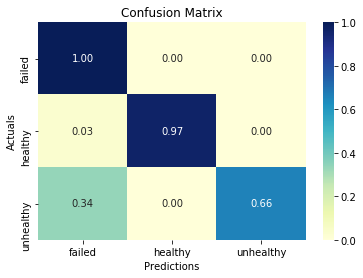

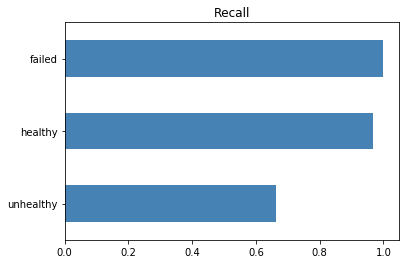

In [14]:
evaluate_metrics(multiclass_predictor, test_features, test_labels)

In [15]:
def delete_endpoint(multiclass_predictor):
    try:
        boto3.client('sagemaker').delete_endpoint(EndpointName=predictor.endpoint)
        print('Deleted {}'.format(multiclass_predictor.endpoint))
    except:
        print('Already deleted: {}'.format(multiclass_predictor.endpoint))

delete_endpoint(multiclass_predictor)

Already deleted: linear-learner-2020-03-23-20-24-30-565


Accuracy: 0.947


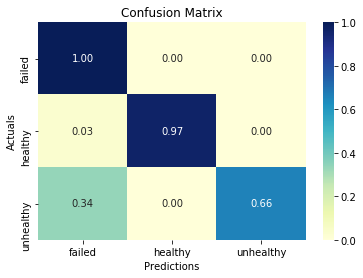

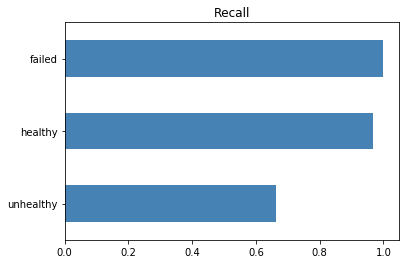

In [16]:
evaluate_metrics(multiclass_predictor, test_features, test_labels)